Ultimate Technologies Inc. is a transportation network company that has disrupted the taxi and logistics industry and is considered a prestigious company to work for.

## Part 1 - Exploratory Data Analysis

In [173]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [174]:
# Load json file into DataFrame
file_path = './data/logins.json'
logins_df = pd.read_json(file_path).set_index('login_time')
logins_df.head()

""
login_time
1970-01-01 20:13:18
1970-01-01 20:16:10
1970-01-01 20:16:37
1970-01-01 20:16:36
1970-01-01 20:26:21


DataFrame is converted to index of type datetime for better and easier manipulation

In [175]:
# Get some information about the dataset
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93142 entries, 1970-01-01 20:13:18 to 1970-04-13 18:54:23
Empty DataFrame


We have 93,143 login information. The date ranges from 01-01-1970 until 04-14-1970

In [176]:
# Check for NaN values
logins_df.isna().sum()

Series([], dtype: float64)

We did not find any NaN values on the DataFrame. 

In [177]:
# Get max and minimum dates
max_date = logins_df.index.max()
min_date = logins_df.index.min()

print(f'Oldest login:\t{min_date}')
print(f'Most recent:\t{max_date}')

Oldest login:	1970-01-01 20:12:16
Most recent:	1970-04-13 18:57:38


Let's add a column called `logins` so it is easier to count the number of logins per time interval

In [178]:
# Set a value of 1 to aggregate index column.
logins_df['logins'] = 1

In [179]:
# Resample to 15 minute time intervals and count logins
resampled_logins = logins_df.resample('15T').count() # minutely frequency
resampled_logins

,logins
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2


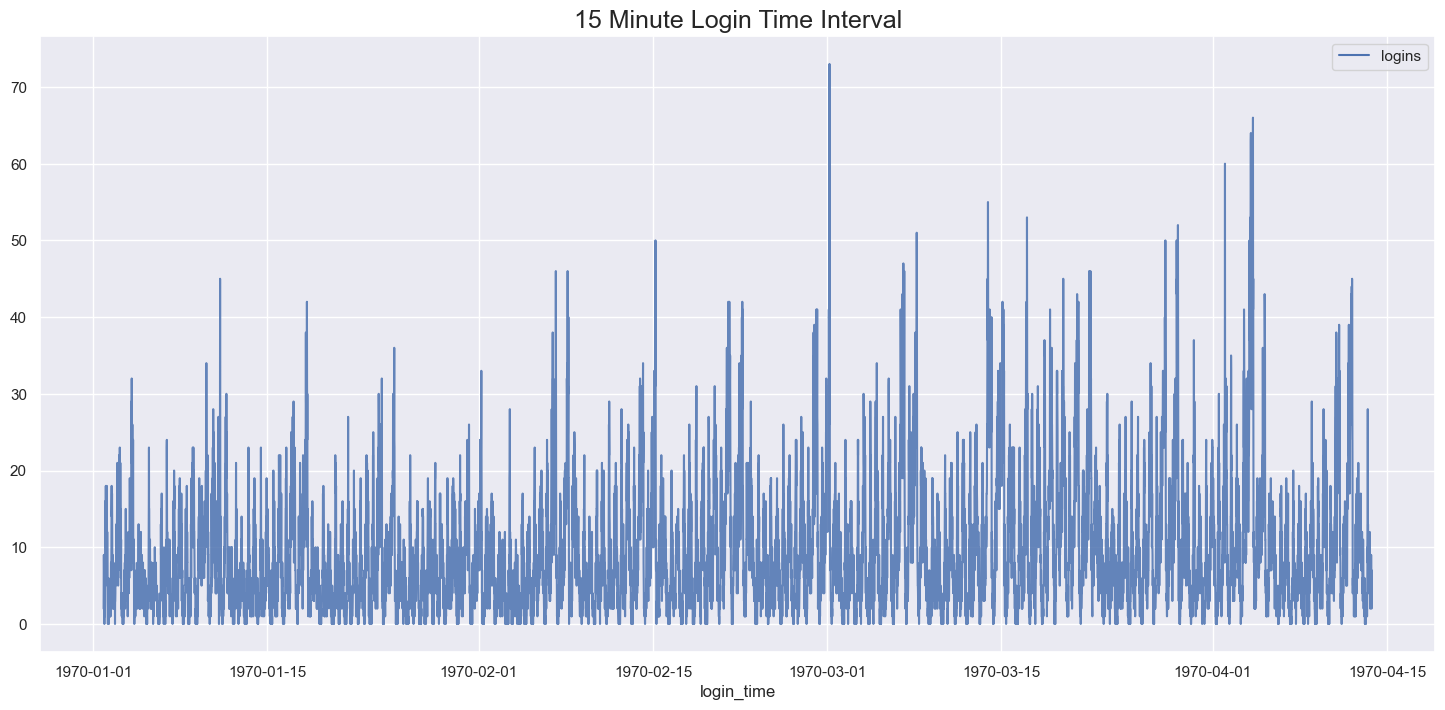

In [180]:
# Visualize login_time
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(18, 8)})
sns.lineplot(data=resampled_logins, alpha=0.85)
plt.title('15 Minute Login Time Interval', fontsize=18)
plt.show()

We can see here that the concentration of data points follows a sinusoidal pattern. 

In [181]:
# Extract day and month from login_time
resampled_logins['month'] = resampled_logins.index.month
resampled_logins['day'] = resampled_logins.index.day
resampled_logins['day_of_week'] = resampled_logins.index.day_of_week # Monday = 0, Sunday = 6
resampled_logins.sample(10)

,logins,month,day,day_of_week
login_time,,,,
1970-04-08 04:15:00,5,4,8,2
1970-04-11 08:45:00,0,4,11,5
1970-03-14 04:45:00,30,3,14,5
1970-02-04 05:15:00,1,2,4,2
1970-04-09 10:45:00,18,4,9,3
1970-01-15 19:45:00,6,1,15,3
1970-01-07 08:00:00,2,1,7,2
1970-02-04 16:30:00,4,2,4,2
1970-03-10 00:45:00,12,3,10,1


In [182]:
resampled_logins.describe()

,logins,month,day,day_of_week
count,9788.000000,9788.000000,9788.000000,9788.000000
mean,9.515938,2.259093,14.569268,3.035554
std,8.328818,1.017219,8.683342,2.012722
min,0.000000,1.000000,1.000000,0.000000
25%,3.000000,1.000000,7.000000,1.000000
50%,7.000000,2.000000,14.000000,3.000000
75%,13.000000,3.000000,22.000000,5.000000
max,73.000000,4.000000,31.000000,6.000000


We can notice outliers on the number of logins. Let's analyze the data above 99% percentile 

In [241]:
# Get the value where 99% of data lies below
percentile_99 = np.quantile(resampled_logins['logins'], 0.99)
df_99 = resampled_logins.loc[resampled_logins['logins'] > percentile_99]
print(f'99th Percentile:\t{percentile_99}')
df_99['day_of_week'].value_counts().sort_index()


99th Percentile:	38.0


1     2
2     2
3     1
4    10
5    37
6    40
Name: day_of_week, dtype: int64

There is record of more than 38 logins per day, except for Sunday.

In [218]:
df_99.loc[df_99['logins'] == 73]

,logins,month,day,day_of_week
login_time,,,,
1970-03-01 04:30:00,73,3,1,6


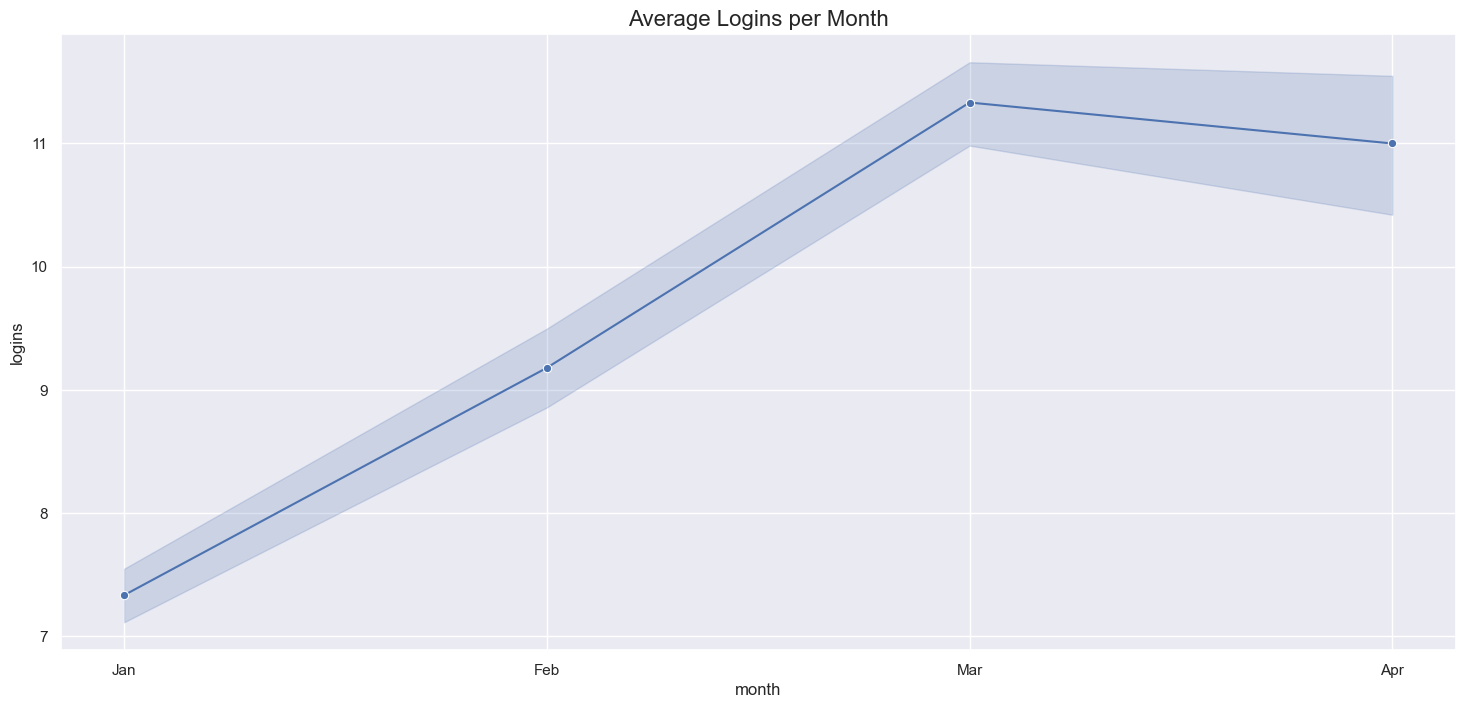

In [183]:
# Visualize average of logins per month.
sns.lineplot(data=resampled_logins, x='month', y='logins',
            markers=True, marker='o')
plt.title('Average Logins per Month', fontsize=16)
ax = plt.gca()
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr']) 
plt.show()

We can see that the amount of logins has increase from January to April. March being the month with more logins.

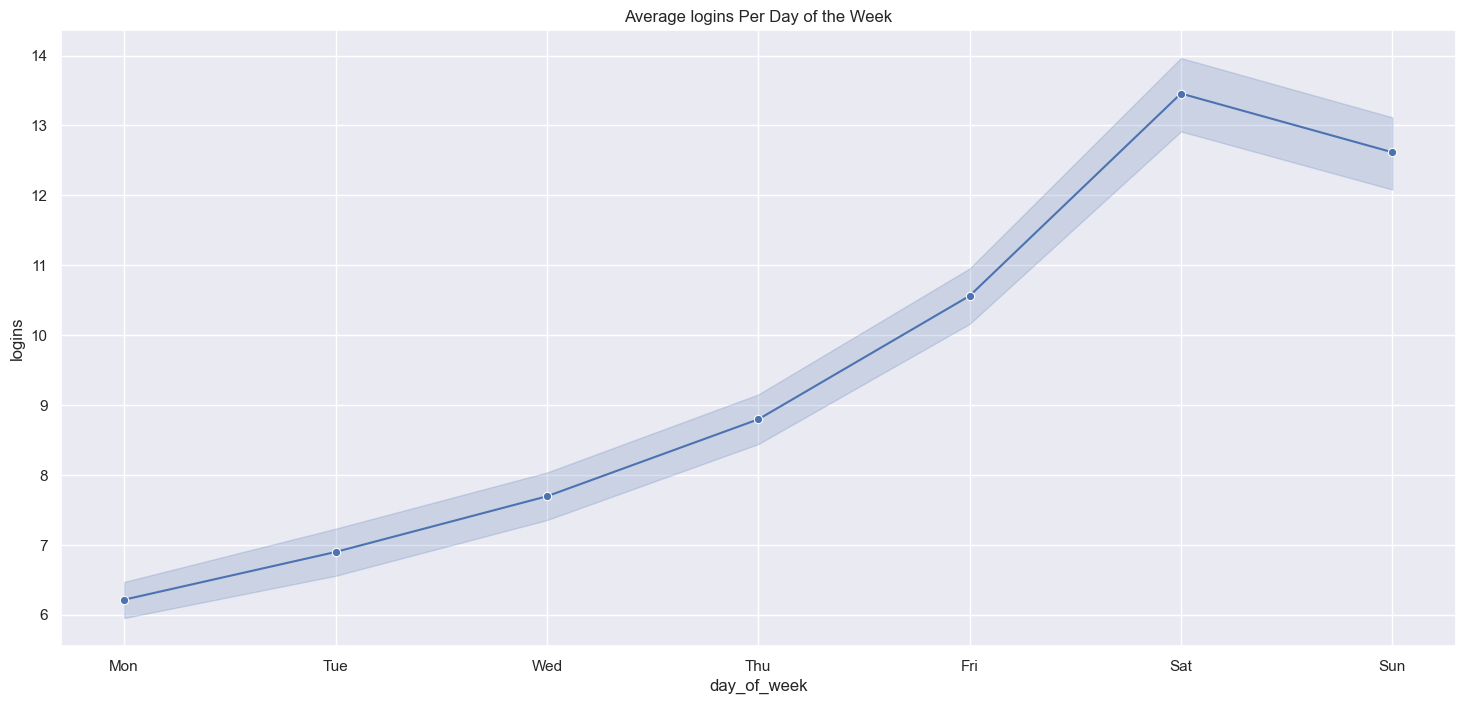

In [184]:
# Visualize 
sns.lineplot(data=resampled_logins, x='day_of_week', y='logins', 
            markers=True, marker='o')
ax = plt.gca()
ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title('Average logins Per Day of the Week')
plt.show()

We can say that the days with most logins are the weekends which makes sense beaucase people have more free time on weekends.

As we see that Saturday is the dat with the most logins, Let's dig a little further.

Let's examine the date with daily frequency

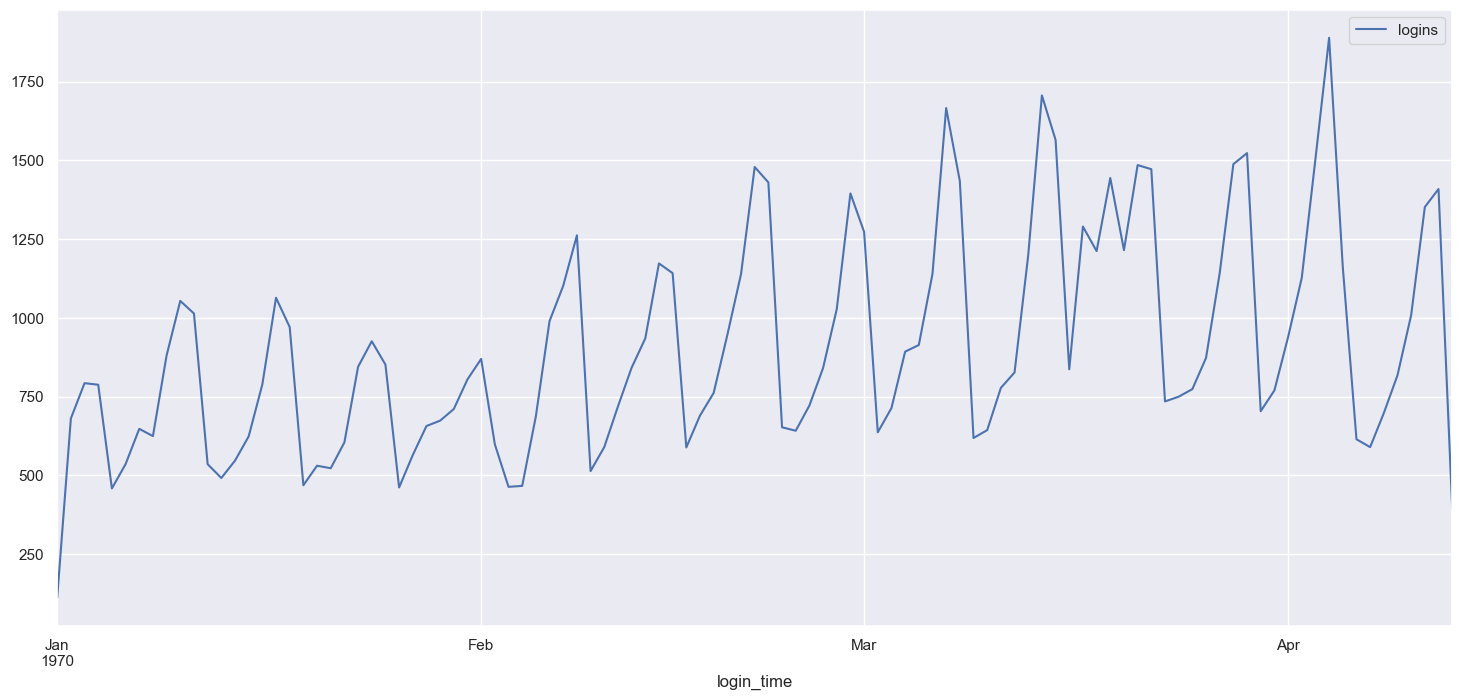

In [245]:
# Daily resample of data
ax = logins_df.resample(rule='D').count().plot()

The spikes represent weekends.

## Part 2 - Experiment and metrics design

Gotham
Metropolis

Gotham most active at night
Metropolis most active during the day

Weekends both cities

two way toll.
driver partners available in both cities ; reimbursing all toll costs

1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

Gotham and Metropolis have complementary circadian rhythms. So, we first need to ask if there is more demand for drivers in each city outside the activation time of the day. Assuming drivers from one city after active hours are willing to be available in the other city and do not need rest, the key measure of success will be an increase in the number of active drivers in each city while active hours.

2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success.
We are going to focus on the weekends because on those days both cities are reasonably active. The best way to track driving partners serving both cities is by tracking their location. We can track their initial location and then every city that they have been available. 

To prove this experiment we can use a parametric statistical test along with a Z-test. We define the null and alternative hypotheses:
Ho: There is no change in population activity
Ha: There is a change in population activity (active in both cities)
The activity is reflected by the time each driver spends in each city. 
If we get to reject the Ho, we can say that reimbursing toll costs is making drivers active in both cities during the weekend, but this does not mean that both cities are not losing money by reimbursing toll costs. 
